In [1]:
#from master import MASTERModel
from master_strategy import MASTERModel
import pickle
import numpy as np
import time
import pandas as pd
import sys, os
import qlib
from qlib.data.dataset import TSDataSampler

# Move up one directory from MASTER-master
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)


from alpha_101.alpha_generator import get_alpha101_table_from_db
from alpha_101.alpha_generator import generate_alphas

In [2]:
# Call generate_alphas() which returns (df, final_df)
df, final_df = generate_alphas(input_schema = 'datacollection',
                    input_table_name = 'stock_data',
                    save = True, 
                    output_schema = 'datacollection',
                    output_table_name = 'alpha101',
                    if_return = True)

KeyboardInterrupt: 

In [84]:
df_all, final_df_all, df_index = get_alpha101_table_from_db()

In [85]:
company_list = company_list = ["ADBE", "AMD", "ABNB", "GOOGL", "GOOG", "AMZN", "AEP", "AMGN", 
"ADI", "ANSS", "AAPL", "AMAT", "APP", "ASML", "AZN", 
"TEAM", "ADSK", "ADP", "AXON", "BKR", "BIIB", "BKNG", "AVGO", 
"CDNS", "CDW", "CHTR", "CTAS", "CSCO", "CCEP", "CTSH", "CMCSA", 
"CPRT", "CSGP", "COST", "CRWD", "CSX", "DDOG", "DXCM","VRTX", "WBD", "WDAY", "XEL", "ZS","QCOM", 
"REGN", "ROP", "ROST", "FAST", "FTNT", "GILD" ,"ON", "PCAR", "PLTR", "PANW","PAYX", "PYPL", 
"PDD", "PEP","SBUX", "SNPS", "TTWO", "TMUS","TSLA", "TXN", "TTD", "VRSK"] 

'''
company_list = company_list = ["ADBE", "AMD", "ABNB", "GOOGL", "GOOG", "AMZN", "AEP", "AMGN", 
"ADI", "ANSS", "AAPL", "AMAT", "APP", "ARM", "ASML", "AZN", 
"TEAM", "ADSK", "ADP", "AXON", "BKR", "BIIB", "BKNG", "AVGO", 
"CDNS", "CDW", "CHTR", "CTAS", "CSCO", "CCEP", "CTSH", "CMCSA", 
"CEG", "CPRT", "CSGP", "COST", "CRWD", "CSX", "DDOG", "DXCM","VRTX", "WBD", "WDAY", "XEL", "ZS","QCOM", 
"REGN", "ROP", "ROST", "FAST", "FTNT", "GEHC", "GILD" ,"ON", "PCAR", "PLTR", "PANW","PAYX", "PYPL", 
"PDD", "PEP","SBUX", "SNPS", "TTWO", "TMUS","TSLA", "TXN", "TTD", "VRSK"]      '''


'\ncompany_list = company_list = ["ADBE", "AMD", "ABNB", "GOOGL", "GOOG", "AMZN", "AEP", "AMGN", \n"ADI", "ANSS", "AAPL", "AMAT", "APP", "ARM", "ASML", "AZN", \n"TEAM", "ADSK", "ADP", "AXON", "BKR", "BIIB", "BKNG", "AVGO", \n"CDNS", "CDW", "CHTR", "CTAS", "CSCO", "CCEP", "CTSH", "CMCSA", \n"CEG", "CPRT", "CSGP", "COST", "CRWD", "CSX", "DDOG", "DXCM","VRTX", "WBD", "WDAY", "XEL", "ZS","QCOM", \n"REGN", "ROP", "ROST", "FAST", "FTNT", "GEHC", "GILD" ,"ON", "PCAR", "PLTR", "PANW","PAYX", "PYPL", \n"PDD", "PEP","SBUX", "SNPS", "TTWO", "TMUS","TSLA", "TXN", "TTD", "VRSK"]      '

In [98]:
df_all = df_all[df_all['Date'] != "2025-03-25"]
final_df_all = final_df_all[final_df_all['Date'] != "2025-03-25"]

In [100]:
filtered_df_all = df_all[df_all['Ticker'].isin(company_list)]
filtered_final_df_all = final_df_all[final_df_all['Ticker'].isin(company_list)]


In [101]:
filtered_df_all.to_csv("df_all.csv", index=False)
filtered_final_df_all.to_csv("final_df_all.csv", index=False)
df_index.to_csv("df_index.csv", index=False)

In [2]:

df_all = pd.read_csv("df_all.csv")
final_df_all = pd.read_csv("final_df_all.csv")
df_index = pd.read_csv("df_index.csv")

In [3]:
# 1) Drop the "IndexTicker" and "Volume" column if it exists
df_index = df_index.drop(columns="IndexTicker", errors="ignore")
df_index = df_index.drop(columns="Volume", errors="ignore")

# 2) Pivot the DataFrame
df_index_pivot = df_index.pivot(
    index="Date",                # Each Date becomes a row
    columns="IndexName",         # Each unique IndexName becomes columns
    values=["Open", "High", "Low", "Close", "Adj_Close"]
)

# 3) Flatten and rename columns to single-level format "<IndexName>_<Column>"
df_index_pivot.columns = [
    f"{col[1]}_{col[0]}"  # col is a tuple like ("Open", "S&P500")
    for col in df_index_pivot.columns
]

# 4) Move the 'Date' index back into a column
df_index_pivot.reset_index(inplace=True)

# Now df_index_pivot has columns like:
# ['Date', 'S&P500_Open', 'S&P500_High', 'S&P500_Low', 'S&P500_Close', 'S&P500_Adj_Close', 'S&P500_Volume', ...]

# Merge on "Date" and "Ticker" (adjust join type if needed)
combined_df = pd.merge(df_all, final_df_all, on=["Date", "Ticker"], how="inner")

# 5) (Optional) Merge with your main DataFrame on 'Date'
df_merged = pd.merge(
    combined_df,
    df_index_pivot,
    on='Date',    # or how='left'/'right'/'outer' if needed
    how='left'
)


df_merged.fillna(0, inplace=True)

# Example of dropping non-numeric columns:
filtered_df_merged = df_merged.drop(columns=["IndClass_Sector", "IndClass_Industry"])

df_sorted = filtered_df_merged.sort_values(by='Date').reset_index(drop=True)

In [ ]:
# Ensure the Date column is datetime type.
df_sorted['Date'] = pd.to_datetime(df_sorted['Date'])

# Get the sorted unique dates.
unique_dates = np.sort(df_sorted['Date'].unique())

# Define split indices based on unique dates.
n_dates = len(unique_dates)
train_date_end = unique_dates[int(n_dates * 0.6)]
valid_date_end = unique_dates[int(n_dates * 0.8)]

# Now split the DataFrame based on the date thresholds.
df_train = df_sorted[df_sorted['Date'] <= train_date_end].copy()
df_valid = df_sorted[(df_sorted['Date'] > train_date_end) & (df_sorted['Date'] <= valid_date_end)].copy()
df_test  = df_sorted[(df_sorted['Date'] > valid_date_end)].copy()


# Optionally, fill missing values.
#df_train.fillna(0, inplace=True)
#df_valid.fillna(0, inplace=True)
#df_test.fillna(0, inplace=True)

# For debugging, you can print the date ranges:
print("Training date range:", df_train['Date'].min(), "-", df_train['Date'].max())
print("Validation date range:", df_valid['Date'].min(), "-", df_valid['Date'].max())
print("Testing date range:", df_test['Date'].min(), "-", df_test['Date'].max())
print("All date range:", df_all['Date'].min(), "-", df_all['Date'].max())


Training date range: 2022-01-03 00:00:00 - 2023-12-06 00:00:00
Validation date range: 2023-12-07 00:00:00 - 2024-07-31 00:00:00
Testing date range: 2024-08-01 00:00:00 - 2025-03-24 00:00:00
All date range: 2022-01-03 - 2025-03-24


In [77]:
def convert_data_qlibformat(df):
    import pandas as pd
    import numpy as np
    from qlib.data.dataset import TSDataSampler  # adjust import as needed

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()
    
    # remove rows with missing "Return" values
    df.dropna(subset=['Return'], inplace=True)
    
    # 1) Ensure the "Date" column is a datetime type
    df["Date"] = pd.to_datetime(df["Date"])
    
    # 2) Separate label and features BEFORE setting the index
    #    Retain "Date" and "Ticker" for indexing, but remove them from features.
    df_label = df[["Return"]].copy()
    # Exclude "Date" and "Ticker" along with "Return" from features
    df_feature = df.drop(columns=["Return", "Date", "Ticker"], errors="ignore")
    
    # 3) Normalize feature columns (ensure they are numeric)
    df_feature = df_feature.apply(pd.to_numeric, errors='coerce')
    feature_mean = df_feature.mean()
    feature_std = df_feature.std()
    eps = 1e-8  # to avoid division by zero
    normalized_feature = (df_feature - feature_mean) / (feature_std + eps)
    df_feature = normalized_feature
    
    # 4) Now set the index of the original DataFrame using "Date" and "Ticker"
    #    These columns will be used as the index ("datetime" and "instrument")
    df_index = df.set_index(["Date", "Ticker"])
    
    # 5) Assign the index to both label and feature DataFrames
    df_feature.index = df_index.index
    df_label.index = df_index.index

    # 6) Construct MultiIndex for the columns:
    #    For features, use top-level "feature"; for the label, use "label"
    df_feature.columns = pd.MultiIndex.from_product([["feature"], df_feature.columns])
    df_label.columns = pd.MultiIndex.from_product([["label"], df_label.columns])
    
    # 7) Concatenate features and label columns, and fill missing values with 0
    df_qlib = pd.concat([df_feature, df_label], axis=1)
    df_qlib = df_qlib.fillna(0)
    
    # 8) Name the index levels and sort the DataFrame
    df_qlib.index.names = ["datetime", "instrument"]
    df_qlib = df_qlib.sort_index(level=["datetime", "instrument"])

    
    # 9) Determine start and end dates from the datetime index level
    start = df_qlib.index.get_level_values("datetime").min()
    end = df_qlib.index.get_level_values("datetime").max()
    
    # 10) Build TSDataSampler (using fillna_type='ffill+bfill' for reindexing)
    sampler = TSDataSampler(df_qlib, start, end, step_len=8, fillna_type='ffill+bfill')
    sampler.data_arr = np.nan_to_num(sampler.data_arr, nan=0.0)
    
    return sampler

# Use the function for training, validation, and test sets:
dl_train = convert_data_qlibformat(df_train)
dl_valid = convert_data_qlibformat(df_valid)
dl_test = convert_data_qlibformat(df_test)


In [72]:
df_train

,Date,Open,High,Low,Close,Volume,Market_Cap,Ticker,Typical_Price,Return,...,NASDAQ 100_Close,Russell 1000_Close,Russell 3000_Close,S&P 500_Close,Wilshire 5000_Close,NASDAQ 100_Adj_Close,Russell 1000_Adj_Close,Russell 3000_Adj_Close,S&P 500_Adj_Close,Wilshire 5000_Adj_Close
0,2022-01-03,566.650024,575.000000,553.270020,564.369995,2862700.0,1.918454e+11,ADBE,564.213338,0.000000,...,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375
1,2022-01-03,66.632004,67.169998,66.122002,66.332001,22591000.0,8.782706e+11,AVGO,66.541334,0.000000,...,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375
2,2022-01-03,188.820007,190.619995,187.460007,190.600006,3781500.0,1.769596e+11,TXN,189.560003,0.000000,...,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375
3,2022-01-03,2423.000000,2466.000000,2396.610107,2461.419922,389000.0,1.623089e+11,BKNG,2441.343343,0.000000,...,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375
4,2022-01-03,240.149994,247.509995,238.070007,244.139999,1642200.0,2.074280e+10,BIIB,243.240000,0.000000,...,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375,16501.769531,2660.780029,2804.929932,4796.560059,48789.359375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32005,2023-12-06,62.310001,63.689999,62.000000,63.630001,2249800.0,4.002753e+10,CCEP,63.106667,0.021676,...,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094
32006,2023-12-06,70.400002,70.910004,70.040001,70.120003,2288900.0,4.130538e+10,CTSH,70.356669,-0.000143,...,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094
32007,2023-12-06,84.889999,85.099998,83.690002,83.790001,1614300.0,3.179671e+10,CSGP,84.193334,-0.004278,...,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094
32008,2023-12-06,37.130001,37.799999,36.299999,36.599998,1929500.0,1.146814e+11,APP,36.899999,-0.012679,...,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094,15788.049805,2495.439941,2609.790039,4549.339844,45854.871094


In [70]:
def convert_data_qlibformat(df, norm_params=None, global_params=None):
    import pandas as pd
    import numpy as np
    from qlib.data.dataset import TSDataSampler  # adjust import as needed

    eps = 1e-8  # to avoid division by zero

    # Create a copy to avoid SettingWithCopyWarning
    df = df.copy()

    # 1) Ensure the "Date" column is a datetime type
    df["Date"] = pd.to_datetime(df["Date"])

    # Save the tickers for grouping
    tickers = df["Ticker"]

    # 2) Separate label and features BEFORE setting the index
    df_label = df[["Return"]].copy()
    df_feature = df.drop(columns=["Return", "Date", "Ticker"], errors="ignore")

    # 3) Convert feature columns to numeric
    df_feature = df_feature.apply(pd.to_numeric, errors='coerce')

    # 3.5) Clip feature values using per-column quantiles (e.g., 1% to 99%) to remove extreme outliers
    lower_bounds = df_feature.quantile(0.01)
    upper_bounds = df_feature.quantile(0.99)
    df_feature = df_feature.clip(lower=lower_bounds, upper=upper_bounds, axis=1)

    # 4) If norm_params is not provided, compute ticker-specific parameters from the input data.
    #    Also compute global parameters as a fallback.
    if norm_params is None:
        norm_params = {}
        for ticker, group in df_feature.groupby(tickers):
            norm_params[ticker] = {
                'mean': group.mean(),
                'std': group.std()
            }
        global_params = {
            'mean': df_feature.mean(),
            'std': df_feature.std()
        }
    # If norm_params is provided but global_params is not, compute global parameters from the current data.
    elif global_params is None:
        global_params = {
            'mean': df_feature.mean(),
            'std': df_feature.std()
        }

    # 5) Normalize features using ticker-specific parameters if available; otherwise use global parameters.
    normalized_feature = df_feature.groupby(tickers, group_keys=False).apply(
        lambda group: (group - norm_params.get(group.name, global_params)['mean']) /
                      (norm_params.get(group.name, global_params)['std'] + eps)
    )
    df_feature = normalized_feature

    #print(normalized_feature)

    # 6) Set the index of the original DataFrame using "Date" and "Ticker"
    df_index = df.set_index(["Date", "Ticker"])

    # 7) Assign the index to both feature and label DataFrames
    df_feature.index = df_index.index
    df_label.index = df_index.index

    #print(df_label)

    # 8) Construct MultiIndex for the columns:
    #    For features, use top-level "feature"; for the label, use "label"
    df_feature.columns = pd.MultiIndex.from_product([["feature"], df_feature.columns])
    df_label.columns = pd.MultiIndex.from_product([["label"], df_label.columns])
    #print(df_label)
    # 9) Concatenate features and label columns, and fill missing values with 0
    #df_qlib = pd.concat([df_feature, df_label], axis=1).fillna(0)
    df_qlib = pd.concat([df_feature, df_label], axis=1).fillna(0)
    
    
    # 10) Name the index levels and sort the DataFrame
    df_qlib.index.names = ["datetime", "instrument"]
    df_qlib = df_qlib.sort_index(level=["datetime", "instrument"])
    
    print(df_qlib.index)
    # 11) Determine start and end dates from the datetime index level
    start = df_qlib.index.get_level_values("datetime").min()
    end = df_qlib.index.get_level_values("datetime").max()

    # 12) Build TSDataSampler (using fillna_type='ffill+bfill' for reindexing)
    sampler = TSDataSampler(df_qlib, start, end, step_len=8, fillna_type='ffill+bfill')
    sampler.data_arr = np.nan_to_num(sampler.data_arr, nan=0.0)
    #print(sampler )
    # Return sampler along with the normalization parameters so they can be reused.
    return sampler, norm_params, global_params


In [ ]:
dl_train, norm_params, global_params = convert_data_qlibformat(df_train)



MultiIndex([('2022-01-03', 'AAPL'),
            ('2022-01-03', 'ABNB'),
            ('2022-01-03', 'ADBE'),
            ('2022-01-03',  'ADI'),
            ('2022-01-03',  'ADP'),
            ('2022-01-03', 'ADSK'),
            ('2022-01-03',  'AEP'),
            ('2022-01-03', 'AMAT'),
            ('2022-01-03',  'AMD'),
            ('2022-01-03', 'AMGN'),
            ...
            ('2023-12-06', 'TSLA'),
            ('2023-12-06',  'TTD'),
            ('2023-12-06', 'TTWO'),
            ('2023-12-06',  'TXN'),
            ('2023-12-06', 'VRSK'),
            ('2023-12-06', 'VRTX'),
            ('2023-12-06',  'WBD'),
            ('2023-12-06', 'WDAY'),
            ('2023-12-06',  'XEL'),
            ('2023-12-06',   'ZS')],
           names=['datetime', 'instrument'], length=32010)


In [67]:
dl_valid, _, _ = convert_data_qlibformat(df_valid, norm_params=norm_params, global_params=global_params)
dl_test, _, _ = convert_data_qlibformat(df_test, norm_params=norm_params, global_params=global_params)

In [78]:
# Save the merged DataFrame tinpuo a pickle file
with open("training_input.pkl", "wb") as f:
    pickle.dump(dl_train, f)
with open("valid_input.pkl", "wb") as f:
    pickle.dump(dl_valid, f)
with open("testing_input.pkl", "wb") as f:
    pickle.dump(dl_test, f)


In [79]:




with open(f'training_input.pkl', 'rb') as f:
    dl_train = pickle.load(f)
with open(f'valid_input.pkl', 'rb') as f:
    dl_valid = pickle.load(f)
with open(f'testing_input.pkl', 'rb') as f:
    dl_test = pickle.load(f)

In [80]:
# After loading:
with open('testing_input.pkl', 'rb') as f:
    ts_sampler = pickle.load(f)

print(type(ts_sampler))
print(dir(ts_sampler))
print(ts_sampler.__dict__)

# Extract the data array from the sampler
data_arr = ts_sampler.data_arr

# Convert the data array to a DataFrame
data_df = pd.DataFrame(data_arr)

# Display the DataFrame
print(data_df.head())

# Check for any NaN values in the data array
if np.isnan(data_arr).any():
    print("NaN found in ts_sampler.data_arr")
else:
    print("No NaN found in ts_sampler.data_arr")

<class 'qlib.data.dataset.TSDataSampler'>
['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_get_indices', '_get_row_col', 'build_index', 'config', 'data_arr', 'data_index', 'empty', 'end', 'fillna_type', 'flt_idx_map', 'get_index', 'idx_arr', 'idx_df', 'idx_map', 'idx_map2arr', 'nan_idx', 'slice_idx_map_and_data_index', 'start', 'step_len']
{'start': Timestamp('2024-08-01 00:00:00'), 'end': Timestamp('2025-03-24 00:00:00'), 'step_len': 8, 'fillna_type': 'ffill+bfill', 'data_arr': array([[-0.10397142, -0.10866242, -0.11184552, ..., -1.70498035,
        -1.61312919, -0.01675073],
       [-0.11322225, -0.10669897, -0.11060947, ..., -2.1

In [81]:
for i, batch in enumerate(dl_train):
    if i >= 10:
        print(f"Batch {i}:")
        print("  Type:", type(batch))            # Should be <class 'numpy.ndarray'>
        print("  Shape:", batch.shape)           # e.g. (batch_size, step_len, feature_dim)
        # Optionally, print some values:
        print("  Sample data:", batch[:2])       # First 2 samples
    if i >= 121:
        break

Batch 10:
  Type: <class 'numpy.ndarray'>
  Shape: (8, 122)
  Sample data: [[-7.24797900e-02 -7.18842122e-02 -6.81462125e-02 -7.48508160e-02
   3.75722230e+00  5.51328969e+00 -7.16451832e-02 -6.21550800e-01
  -1.63339172e+00 -6.56998831e-02 -1.55293764e-01  1.64023188e+00
  -1.48780110e-01  1.38429525e-02  1.66978224e+00  3.73096150e-01
   3.71479613e-01 -1.16458724e+00  3.57718513e-01  1.67489552e+00
  -1.33481810e-01 -4.81545713e-01  1.66091644e+00  7.75118074e-01
   1.70246842e+00  9.74314610e-02  8.18238888e-01  9.72556984e-01
   5.84883457e-03  1.59962421e-01  5.09575758e-01 -1.64423487e+00
   6.22648085e-01  1.02648476e+00 -2.12779506e+00 -1.51840735e+00
   8.94303817e-01 -1.03558369e+00  5.75245012e-01  7.43693754e-01
  -6.69911244e-01 -1.08650496e+00 -1.00239969e+00  1.10338421e+00
   7.54633790e-01  1.90720200e-02 -1.11586849e-02 -1.83507984e-01
  -1.01292886e+00  8.80643332e-02 -3.02719293e-02  1.31974631e+00
  -6.29391374e-01  4.28554865e-03  5.13126487e-01  3.27747078e+00
 

In [83]:

    
d_feat = 9
d_model = 256
t_nhead = 4
s_nhead = 2
dropout = 0.5
gate_input_start_index = 9
gate_input_end_index = 121

beta = 5

n_epoch = 100
lr = 1e-4
GPU = 0
train_stop_loss_thred = 0.005


ic = []
icir = []
ric = []
ricir = []

In [84]:
#from master import MASTERModel
from master_strategy import MASTERModel
import pickle
import numpy as np
import time
import pandas as pd
import sys, os
import qlib
from qlib.data.dataset import TSDataSampler

# Move up one directory from MASTER-master
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)


from alpha_101.alpha_generator import get_alpha101_table_from_db
from alpha_101.alpha_generator import generate_alphas


df_all = pd.read_csv("df_all.csv")
final_df_all = pd.read_csv("final_df_all.csv")
df_index = pd.read_csv("df_index.csv")


with open(f'training_input.pkl', 'rb') as f:
    dl_train = pickle.load(f)
with open(f'valid_input.pkl', 'rb') as f:
    dl_valid = pickle.load(f)
with open(f'testing_input.pkl', 'rb') as f:
    dl_test = pickle.load(f)
    
d_feat = 9
d_model = 256
t_nhead = 4
s_nhead = 2
dropout = 0.5
gate_input_start_index = 9
gate_input_end_index = 121

beta = 5

n_epoch = 100
lr = 1e-4
GPU = 0
train_stop_loss_thred = 0.005


ic = []
icir = []
ric = []
ricir = []



##Training
######################################################################################
for seed in [0]: # , 1, 2, 3, 4
    model = MASTERModel(
        d_feat = d_feat, d_model = d_model, t_nhead = t_nhead, s_nhead = s_nhead, T_dropout_rate=dropout, S_dropout_rate=dropout,
        beta=beta, gate_input_end_index=gate_input_end_index, gate_input_start_index=gate_input_start_index,
        n_epochs=n_epoch, lr = lr, GPU = GPU, seed = seed, train_stop_loss_thred = train_stop_loss_thred,
        save_path='model', save_prefix=f'model_training'
    )

    start = time.time()
    # Train
    model.fit(dl_train, df_all, dl_valid)

    print("Model Trained.")

    # Test
    # predictions, metrics = model.predict(dl_test)
    ###### 0
    print("Start Prediction")
    predictions, metrics, real_returns, real_prices, market_cap = model.predict(dl_test, df_all)
    ######       
    running_time = time.time()-start
    
    print('Seed: {:d} time cost : {:.2f} sec'.format(seed, running_time))
    print(metrics)

    ic.append(metrics['IC'])
    icir.append(metrics['ICIR'])
    ric.append(metrics['RIC'])
    ricir.append(metrics['RICIR'])

    
######################################################################################

# Load and Test
######################################################################################
for seed in [0]:
    param_path = f'model/model_training_{seed}.pkl'

    print(f'Model Loaded from {param_path}')
    model = MASTERModel(
            d_feat = d_feat, d_model = d_model, t_nhead = t_nhead, s_nhead = s_nhead, T_dropout_rate=dropout, S_dropout_rate=dropout,
            beta=beta, gate_input_end_index=gate_input_end_index, gate_input_start_index=gate_input_start_index,
            n_epochs=n_epoch, lr = lr, GPU = GPU, seed = seed, train_stop_loss_thred = train_stop_loss_thred,
            save_path='model', save_prefix=f'model_prediction'
        )
    model.load_param(param_path)
    ###### 1
    predictions, metrics, real_returns, real_prices, market_cap = model.predict(dl_test, df_all)
    ###### 
    # predictions, metrics = model.predict(dl_test)
    print(metrics)

    ic.append(metrics['IC'])
    icir.append(metrics['ICIR'])
    ric.append(metrics['RIC'])
    ricir.append(metrics['RICIR'])

    ####### 2
    # From Predictions to DataFrame
    df_predictions = predictions.reset_index()  # 让 MultiIndex 变成普通列
    df_predictions.columns = ["Date", "Ticker", "Predicted_Return"]  # Rename Column
    
    df_real_returns = real_returns.reset_index(drop=True)
    df_real_prices = real_prices.reset_index(drop=True)
    df_market_cap = market_cap.reset_index(drop=True)

    # Merge the sheet to the right side.
    df_predictions["Actual_Return"] = df_real_returns
    df_predictions["Price"] = df_real_prices
    df_predictions["Market_Cap"] = df_market_cap


    # To CSV
    csv_path = "predictions_1.csv"
    df_predictions.to_csv(csv_path, index=False)
    ######
       
######################################################################################

print("IC: {:.4f} pm {:.4f}".format(np.mean(ic), np.std(ic)))
print("ICIR: {:.4f} pm {:.4f}".format(np.mean(icir), np.std(icir)))
print("RIC: {:.4f} pm {:.4f}".format(np.mean(ric), np.std(ric)))
print("RICIR: {:.4f} pm {:.4f}".format(np.mean(ricir), np.std(ricir)))


###### 3
print(df_predictions.head())

Epoch: 0
Epoch 0, train_loss 0.048641, valid ic 0.2094, icir 1.413, rankic 0.2338, rankicir 1.677.
Epoch: 1
Epoch 1, train_loss 0.007346, valid ic 0.1650, icir 1.214, rankic 0.1815, rankicir 1.424.
Epoch: 2
Epoch 2, train_loss 0.004734, valid ic 0.3181, icir 2.103, rankic 0.3509, rankicir 2.256.
Model Trained.
Start Prediction
Epoch: 2
Seed: 0 time cost : 52.51 sec
{'IC': np.float64(0.29297386553920923), 'ICIR': np.float64(1.6455739822039117), 'RIC': np.float64(0.32508641662364), 'RICIR': np.float64(1.865959385694934)}
Model Loaded from model/model_training_0.pkl
Epoch: Previously trained.
{'IC': np.float64(0.29297386553920923), 'ICIR': np.float64(1.6455739822039117), 'RIC': np.float64(0.32508641662364), 'RICIR': np.float64(1.865959385694934)}
IC: 0.2930 pm 0.0000
ICIR: 1.6456 pm 0.0000
RIC: 0.3251 pm 0.0000
RICIR: 1.8660 pm 0.0000
        Date Ticker  Predicted_Return  Actual_Return       Price    Market_Cap
0 2024-08-01   AAPL          0.027266      -0.016751  218.360001  3.575710e+1

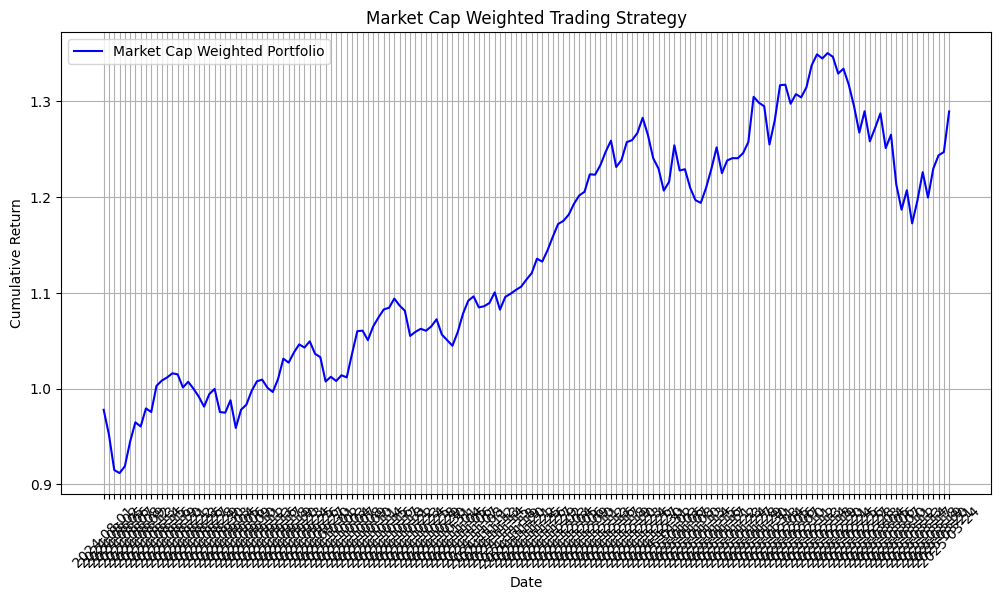

Sharpe Ratio: 1.8221863739627897
Max Drawdown: -13.17%


"\nplt.figure(figsize=(12, 6))\nplt.plot(results['Date'][1:], sharpe_ratio, label='Market Cap Weighted Portfolio', color='b')\nplt.xlabel('Date')\nplt.ylabel('Cumulative Return')\nplt.title('Market Cap Weighted Trading Strategy')\nplt.legend()\nplt.xticks(rotation=90)\nplt.grid()\nplt.show()"

In [85]:
# Strategy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Copy the dataset to avoid modifying the original data
df = pd.read_csv("predictions_1.csv")

# Market Cap Weighted Trading Strategy
#
# This strategy selects the top N stocks each day based on the highest Predicted_Return.
# The selected stocks are weighted by their Market_Cap to determine portfolio allocation.

# Selection parameter
TOP_N = 5  # Number of top stocks selected daily
INITIAL_CAPITAL = 1_000_000  # Initial portfolio value in cash
TRADING_COST_RATE = 0.001  # 0.1% trading cost per transaction

def TopN(df):
    '''
    Strategy Overview:
        1. Daily rebalancing: Selects top N stocks (configurable TOP_N) each day based on highest predicted returns
        2. Market-cap weighting: Allocates capital proportionally to selected stocks' market capitalizations
        3. Realistic execution: 
            - Calculates position sizes using daily closing prices
            - Applies trading costs (0.1% per trade) for position changes
            - Tracks portfolio value with compounding returns
        4. Key mechanics:
            - Maintains daily position tracking to calculate turnover
            - Uses actual returns (not predictions) for performance calculation
            - Automatically handles missing positions as zero-weight allocations
        5. Output: Calculates cumulative returns, Sharpe ratio, and max drawdown
    '''
    # Ensure data is sorted by date
    df = df.sort_values(by=['Date'])
    unique_dates = df['Date'].unique()
    portfolio_value = INITIAL_CAPITAL  # Track portfolio value
    portfolio_returns = []
    portfolio_values = []
    prev_positions = {}  # Store previous day's holdings
    
    for date in unique_dates:
        daily_data = df[df['Date'] == date]
        
        # Select top N stocks based on Predicted_Return
        top_stocks = daily_data.nlargest(TOP_N, 'Predicted_Return')
        tickers = top_stocks['Ticker'].values
        prices = top_stocks['Price'].values
        market_caps = top_stocks['Market_Cap'].values
        
        # Compute market cap weighted allocation
        weights = market_caps / np.sum(market_caps)
        allocation = portfolio_value * weights  # Allocate capital based on weight
        new_positions = {ticker: alloc / price for ticker, alloc, price in zip(tickers, allocation, prices)}
        
        # Compute trading cost
        trading_cost = 0
        for ticker, new_shares in new_positions.items():
            prev_shares = prev_positions.get(ticker, 0)
            trading_cost += abs(new_shares - prev_shares) * prices[list(tickers).index(ticker)] * TRADING_COST_RATE
            
        for ticker, prev_shares in prev_positions.items():
            if ticker not in new_positions:
                last_price = df[(df['Date'] == date) & (df['Ticker'] == ticker)]['Price'].values
                if len(last_price) > 0: 
                    trading_cost += abs(prev_shares) * last_price[0] * TRADING_COST_RATE
                    
        # Compute portfolio return based on price changes
        actual_returns = top_stocks['Actual_Return'].values
        portfolio_return = np.sum(weights * actual_returns)
        
        # Update portfolio value
        portfolio_value *= (1 + portfolio_return)
        portfolio_value -= trading_cost  # Deduct trading cost
        prev_positions = new_positions  # Update holdings
        
        portfolio_returns.append(portfolio_return)
        portfolio_values.append(portfolio_value)
    
    # Convert results to DataFrame
    results = pd.DataFrame({'Date': unique_dates, 'Portfolio_Value': portfolio_values, 'Portfolio_Return': portfolio_returns})
    results['Cumulative_Return'] = results['Portfolio_Value'] / INITIAL_CAPITAL
    
    return results

# Run backtest
results = TopN(df)

# Plot cumulative return

plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Cumulative_Return'], label='Market Cap Weighted Portfolio', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Market Cap Weighted Trading Strategy')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.show()



# Compute performance metrics
risk_free_rate = 0.04 / 252
epsilon = 1e-8  # Small value to avoid division by zero
portfolio_daily_returns = results['Cumulative_Return'].pct_change().dropna() # results['Portfolio_Return']
excess_returns = portfolio_daily_returns - risk_free_rate
sharpe_ratio = (excess_returns.mean() / (excess_returns.std() + epsilon)) * np.sqrt(252)

max_drawdown = (results['Cumulative_Return'] / results['Cumulative_Return'].cummax() - 1).min()

print(f"Sharpe Ratio: {sharpe_ratio}")
print(f"Max Drawdown: {max_drawdown:.2%}")

######
'''
plt.figure(figsize=(12, 6))
plt.plot(results['Date'][1:], sharpe_ratio, label='Market Cap Weighted Portfolio', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Market Cap Weighted Trading Strategy')
plt.legend()
plt.xticks(rotation=90)
plt.grid()
plt.show()'''
